# Bonusaufgabe 1 - Ames housing 
### Von Chengyi Hua - 8883221

In [1]:
#loading dependencies and library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.regressor import StackingCVRegressor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Getting insights into the dataset


In [2]:
#Load data
data =  pd.read_csv("data/ames.csv")
data.head()


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


In [3]:
numCols = list(data.select_dtypes(exclude='object').columns)
print(f" {len(numCols)} numerical features:\n", numCols)

 35 numerical features:
 ['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold', 'Sale_Price', 'Longitude', 'Latitude']


In [4]:
catCols = list(data.select_dtypes(include='object').columns)
print(f" {len(catCols)} categorial features:\n", catCols)

 46 categorial features:
 ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence', 'Misc_Feature', 'Sale_Type', 'Sale_Condition']


In [5]:
# Using an initail split to showcase the data. Will not be used for modelling
train_init = data.iloc[0:2000]

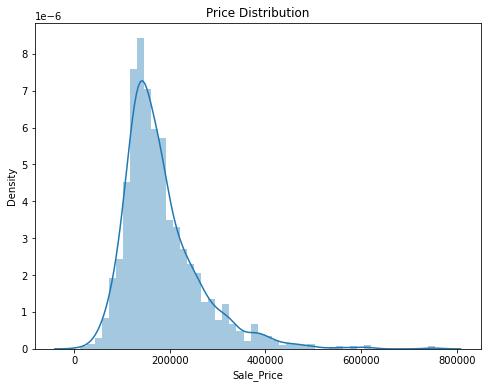

In [6]:
# Situation plot of Sale_Price in train dataset
data_for_plot = train_init.Sale_Price
plt.figure(figsize=(8,6))
sns.distplot(data_for_plot)
title = plt.title("Price Distribution")

In [7]:
# First glanz into the correaltion of features with the target variable: Sale_Price
corr_mat_initial = train_init.corr().Sale_Price.sort_values(ascending=False)
corr_mat_initial.head(11)

Sale_Price        1.000000
Gr_Liv_Area       0.703783
Total_Bsmt_SF     0.660540
Garage_Area       0.660196
Garage_Cars       0.655443
First_Flr_SF      0.648710
Year_Built        0.576502
Year_Remod_Add    0.533495
Full_Bath         0.526277
Mas_Vnr_Area      0.510476
TotRms_AbvGrd     0.487468
Name: Sale_Price, dtype: float64

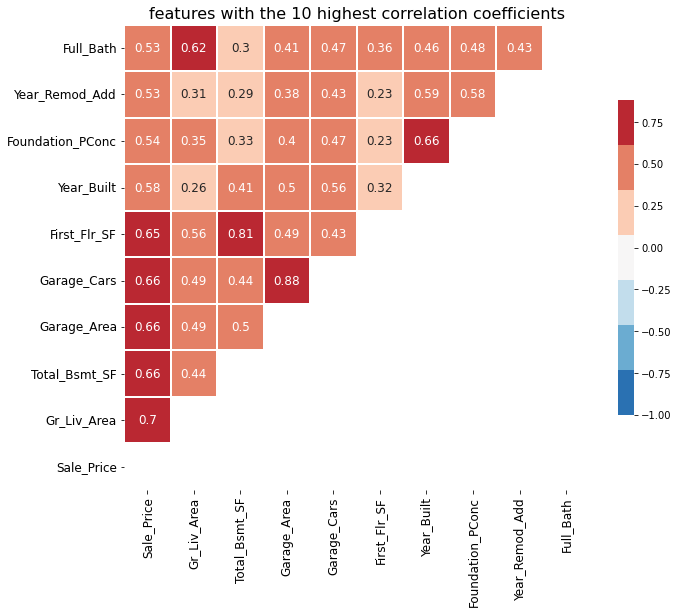

In [10]:
# showcase the first correlation at this stage. Similar to the section above. 

train_dummies = pd.get_dummies(train_init, drop_first = True)
# get index of columns with 10 highest corrcoef wrt saleprice
corr_cols = train_dummies.corr().nlargest(10, 'Sale_Price').index

# create heatmap
mask = np.zeros_like(train_dummies[corr_cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_dummies[corr_cols].corr(), 
            annot=True, 
            square= True, 
            mask = mask,
            cmap=sns.color_palette("RdBu_r", 7),
            annot_kws={'size': 12},
            cbar_kws={"shrink": 0.5},
            linewidth = 0.1,
            yticklabels=corr_cols.values, 
            xticklabels=corr_cols.values,
            vmin = -1)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.tick_params(labelsize=12)
plt.title('features with the 10 highest correlation coefficients', fontsize=16)
plt.tight_layout()

## Data preprocessing

Data preprocessing transforms the data into a format that is more easily and effectively processed in data mining, machine learning and other data science tasks. The techniques are generally used at the earliest stages of the machine learning and AI development pipeline to ensure accurate results.

### Missing values
Handling na´s in the dataset. For categorial and numerical attributes. Many machine learning algorithms fail if the dataset contains missing values. You may end up building a biased machine learning model which will lead to incorrect results if the missing values are not handled.


In [16]:
class FillingMissings (BaseEstimator, TransformerMixin):
     def fit (self, X, y=None):
            return self
     def transform(self, X):    
         col_numerical = [col for col in X.columns if X[col].dtype != np.object]
         col_categorical = [col for col in X.columns if col not in col_numerical]

         for col in col_numerical:
           X[col] = X[col].fillna(0.0)
         for col in col_categorical:
           X[col] = X[col].fillna('None')
         return X
    
#train_copy.head(50)

### Adding new features, using provided information

In [17]:
class FratureAdd (BaseEstimator, TransformerMixin):
    def fit (self, X, y=None):
            return self
    def transform(self, X):
            X['total_SqFeet'] = X['Total_Bsmt_SF'] + X['First_Flr_SF'] + X['Second_Flr_SF']
            X['total_Bathroom'] = X.Full_Bath + X.Bsmt_Full_Bath + 0.5 * (X.Half_Bath + X.Bsmt_Half_Bath)
            X['ageofhouse'] = X.Year_Sold - X.Year_Built
            X['reModelled'] = np.where(X.Year_Remod_Add == X.Year_Built, 0, 1)
            X['is_new'] = np.where(X.Year_Sold == X.Year_Built, 1, 0)
            return X


### Deleting some existing features
Collinear features will be dropped.There is multicollinearity in our training data. Multicolliniearity has a negative impact on our prediction models and makes standard errors of our estimates increase. 
Therefore, for each pair of highly correlated features Below features are highly correlated:

- Garage_Cars and Garage_Area
- First_Flr_SF and Total_Bsmt_SF
- Gr_Liv_Area and TotRms_AbvGrd
- Exterior_1st and Mas_Vnr_Type
- BsmtFin_Type_1 and BsmtFin_Type_2

Within the pairs the one with a lower corr with Sale_Price will be deleted. In this case: Garage_Cars, First_Flr_SF, and TotRms_AbvGrd

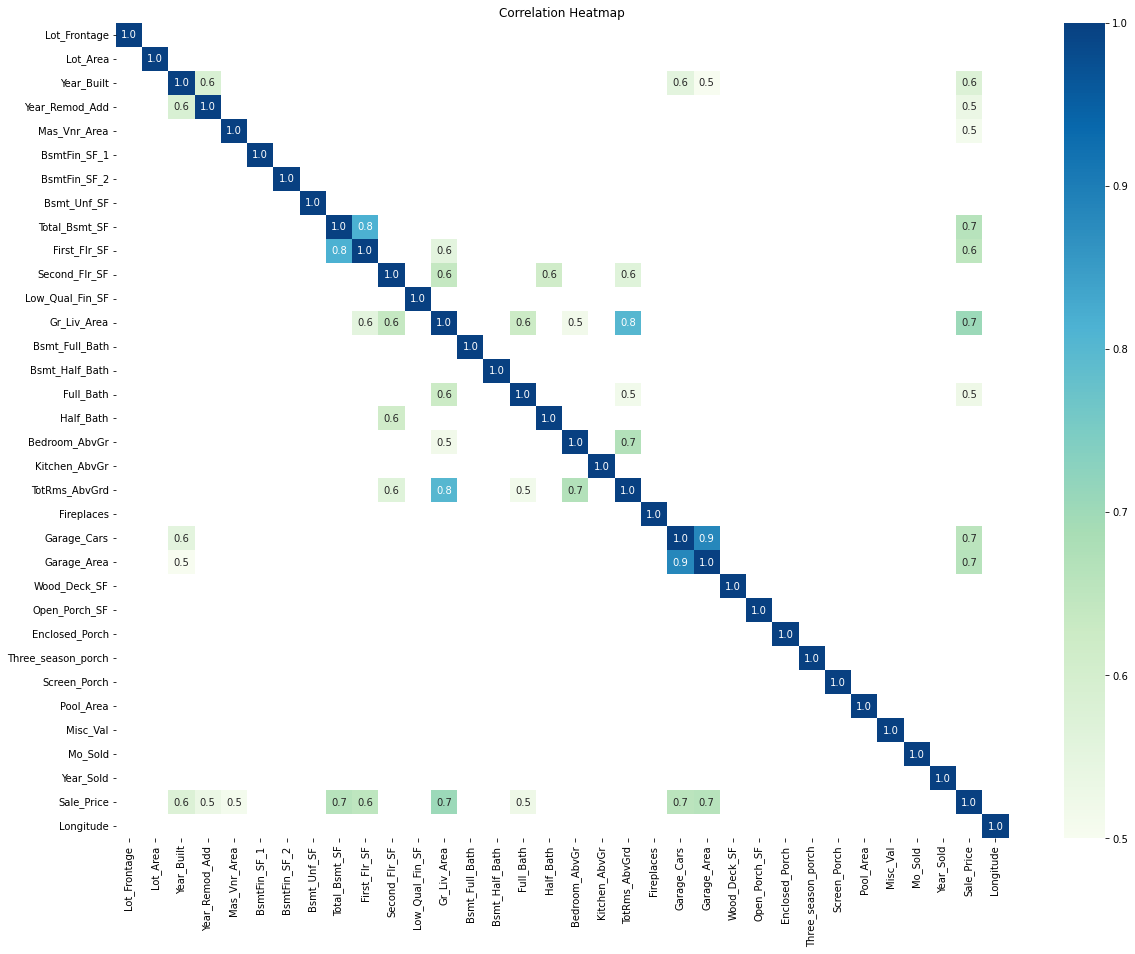

In [20]:
corr_mat = train_init.iloc[:, :-1].corr()
# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]
# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

In [18]:
#corr_general = train_init.corr().Sale_Price.sort_values(ascending=True)
#corr_general.head(60)

In [13]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None):
        return self
    def transform (self, X):
        return X.drop(columns=['Garage_Cars', 'First_Flr_SF', 
                    'TotRms_AbvGrd'], axis = 1)
        

        


### Label Encoding
In label encoding in Python, we replace the categorical value with a numeric value between 0 and the number of classes minus 1. If the categorical variable value contains 5 distinct classes, we use (0, 1, 2, 3, and 4).

In [18]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None):
        return self
    def transform (self, X):
        label_encoding_cols = ['MS_SubClass', 'MS_Zoning', 'Street', 
                       'Alley', 'Lot_Shape', 'Land_Contour', 
                       'Utilities', 'Lot_Config', 'Land_Slope', 
                       'Neighborhood', 'Condition_1', 'Condition_2',
                       'Bldg_Type', 'House_Style', 'Overall_Qual', 
                       'Overall_Cond', 'Roof_Style', 'Roof_Matl', 
                       'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type',
                       'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 
                       'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                       'Central_Air', 'Electrical', 'Kitchen_Qual', 
                       'Functional', 'Fireplace_Qu', 'Garage_Type', 
                       'Garage_Finish', 'Garage_Qual', 'Garage_Cond',
                       'Paved_Drive', 'Pool_QC', 'Fence', 'Misc_Feature',
                       'Sale_Type', 'Sale_Condition']
        label_encoder = LabelEncoder()
        # Apply Label Encoder on data
        for col in label_encoding_cols:
         X[col] = label_encoder.fit_transform(X[col])
        return X
        
    


## Data preprocessing pipeline

In [23]:
pipe = Pipeline([
    ("missingna", FillingMissings()),
    ("adder", FratureAdd()),
    ("dropper", FeatureDropper()),
    ("encoder", FeatureEncoder())
     
     ])

data_for_split = pipe.fit_transform(data)

## Modeling and cross validation


In [24]:
train = data_for_split.iloc[0:2000]
test = data_for_split.iloc[2001:]
print("Train data's size: ", train.shape)
print("Test data's size: ", test.shape)

# Seperate train data for further usage (excluding Sale_Price)
x = train.drop(columns = ['Sale_Price'], axis = 1)
#Sets target variable (Sale Price) as y
y = train['Sale_Price']


Train data's size:  (2000, 83)
Test data's size:  (929, 83)


### Stacking and cross validation


In [47]:
RANDOM_SEED = 42

svr = SVR(kernel='linear')
lasso = Lasso()
rf = RandomForestRegressor(n_estimators=5, 
                           random_state=RANDOM_SEED)

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
stack = StackingCVRegressor(regressors=(svr, lasso, rf),
                            meta_regressor=lasso,
                            random_state=RANDOM_SEED)

print('5-fold cross validation scores:\n')

for clf, label in zip([svr, lasso, rf, stack], ['SVM', 'Lasso', 
                                                'Random Forest', 
                                                'StackingCVRegressor']):
    scores = cross_val_score(clf, x, y, cv=5)
    print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (
        scores.mean(), scores.std(), label))


5-fold cross validation scores:

R^2 Score: 0.70 (+/- 0.22) [SVM]
R^2 Score: 0.74 (+/- 0.25) [Lasso]
R^2 Score: 0.82 (+/- 0.07) [Random Forest]
R^2 Score: 0.81 (+/- 0.13) [StackingCVRegressor]


### Prediction with the Random Forest algorithm

In [63]:
# Seperate train data for further usage (excluding Sale_Price)
x_test = test.drop(columns = ['Sale_Price'], axis = 1)
#Sets target variable (Sale Price) as y
y_test = test['Sale_Price']

rf.fit(x,y)
rf.score(x_test, y_test)
#rf.predict(x_test)

0.8384835809313407

## Conclusion

The result show, the trained Random Forest algorithm has the highest score related to cross validation scores mean using a 5 fold cross validation. It is slightly higher than the StackingCVRegression model. In the next step, we can test the performance of the models on test data. The mean accuracy on the given test data and labels (extracted previouly) is round 83%. To enhance the model, more investigations into feature selection/tuning can be conducted. However, this is not within the scope of this assignment. 

